# Capital One Data Challenge 

## By Praveen Balasubramanian

## Part - 1

## Data Munging

In [1]:
'''Import Packages'''
import pandas as pd
import datetime
import json
import os
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import sys,traceback
%matplotlib inline

In [2]:
'''Function to load the HMDA dataset'''
def hmda_init(loan_filepath,institution_filepath):

    inst_data = pd.read_csv(institution_filepath,low_memory= False)
    loan_data = pd.read_csv(loan_filepath,low_memory= False)

    tmp_filter_df = pd.DataFrame()
    tmp_filter_df['Respondent_Name_TS'] = pd.DataFrame(inst_data['Respondent_Name_TS'])
    loan_col_list = list(loan_data)
    inst_col_list = list(inst_data)
    common_list = list(set(loan_col_list).intersection(inst_col_list))
    for common_column in common_list:
        tmp_filter_df[str(common_column)] = pd.DataFrame(inst_data[str(common_column)])

    print "Merging two datasets"
    join_data = loan_data.merge(tmp_filter_df, how = 'left', on = common_list)
    print "Loaded successfully."
    
    return join_data,inst_data

In [3]:
'''User interacive way to access the dataset'''
c = 1
while (c!=0):
    loans_filepath = str(raw_input("Enter loans_data filepath:"))
    institution_filepath = str(raw_input("Enter institution_data filepath:"))
    if os.path.isfile(loans_filepath) and os.path.isfile(institution_filepath):
        merged_data,inst_data = hmda_init(loans_filepath,institution_filepath)
    else:
        '''Add double slash in filepath and try again!'''
        loans_filepath = re.escape(loans_filepath)
        institution_filepath = re.escape(institution_filepath)
        merged_data,inst_data = hmda_init(loans_filepath,institution_filepath)
    if type(merged_data) != str: c = 0
    else: print "Check if file exists in the filepath and Let's try again ! \n"
        
#C:\Users\praveenb\Desktop\New folder\Capital\2012_to_2014_loans_data.csv
#C:\Users\praveenb\Desktop\New folder\Capital\2012_to_2014_institutions_data.csv

Enter loans_data filepath:C:\Users\praveenb\Desktop\New folder\Capital\2012_to_2014_loans_data.csv
Enter institution_data filepath:C:\Users\praveenb\Desktop\New folder\Capital\2012_to_2014_institutions_data.csv
Merging two datasets
Loaded successfully.


In [4]:
'''Function to export filtered dataset to a json output file. Filters on States and conventional_conforming flag options.'''
def hmda_to_json(df, states=None, cc=None):
    
    if states is not None and cc is not None:
        result = df.loc[(df['Conventional_Conforming_Flag'] == cc) & df['State'].isin(states)]
    elif states is None and cc is not None:
        result = df.loc[(df['Conventional_Conforming_Flag'] == cc)]
    elif states is not None and cc is None:
        result = df.loc[df['State'].isin(states)]
    elif states is None and cc is None:
        result = df.copy()
        
    d = datetime.datetime.now()
    fname = 'Loan_data_'+str(d)+'.json'
    fname = fname.replace(':','-')
    print result.shape
    with open(fname, 'a+') as f:
        result.to_json(f, force_ascii=False)
        print 'You can find the json file at '+str(os.getcwd())+ ' and the file name is: '+fname
        
    return

In [5]:
hmda_to_json(merged_data, ['WV','DC'], None)
hmda_to_json(merged_data, ['WV'], 'Y')
hmda_to_json(merged_data, ['WV','DC'], 'N')

(127112, 25)
You can find the json file at C:\Users\praveenb\Desktop\New folder\Capital and the file name is: Loan_data_2017-08-20 17-07-53.383000.json
(55844, 25)
You can find the json file at C:\Users\praveenb\Desktop\New folder\Capital and the file name is: Loan_data_2017-08-20 17-07-54.382000.json
(34262, 25)
You can find the json file at C:\Users\praveenb\Desktop\New folder\Capital and the file name is: Loan_data_2017-08-20 17-07-54.850000.json


## Part - 2

## Quality Check

In [6]:
'''Explore the data types of the columns'''
result = merged_data.copy()
result.dtypes

Agency_Code                         int64
Applicant_Income_000               object
As_of_Year                          int64
Census_Tract_Number                object
County_Code                        object
FFIEC_Median_Family_Income         object
Loan_Amount_000                     int64
MSA_MD                             object
Number_of_Owner_Occupied_Units     object
Respondent_ID                      object
Sequence_Number                     int64
State_Code                          int64
Tract_to_MSA_MD_Income_Pct         object
MSA_MD_Description                 object
Loan_Purpose_Description           object
Agency_Code_Description            object
Lien_Status_Description            object
Loan_Type_Description              object
State                              object
County_Name                        object
Conforming_Limit_000              float64
Conventional_Status                object
Conforming_Status                  object
Conventional_Conforming_Flag      

In [7]:
print "Look at all the columns that has Null values"
result.isnull().sum()

Look at all the columns that has Null values


Agency_Code                           0
Applicant_Income_000                  0
As_of_Year                            0
Census_Tract_Number                   0
County_Code                           0
FFIEC_Median_Family_Income            0
Loan_Amount_000                       0
MSA_MD                                0
Number_of_Owner_Occupied_Units        0
Respondent_ID                         0
Sequence_Number                       0
State_Code                            0
Tract_to_MSA_MD_Income_Pct          900
MSA_MD_Description                95217
Loan_Purpose_Description              0
Agency_Code_Description               0
Lien_Status_Description               0
Loan_Type_Description                 0
State                                 0
County_Name                         837
Conforming_Limit_000                837
Conventional_Status                   0
Conforming_Status                     0
Conventional_Conforming_Flag          0
Respondent_Name_TS                    0


In [8]:
'''We can confirm that the Loan_Amount_000 and the respondent_name column don't have any null values on it, 
Lets examine the loan amount column first and check their descriptive stats first'''
result['Loan_Amount_000'].describe()

count    1.321158e+06
mean     2.902331e+02
std      9.657792e+02
min      1.000000e+00
25%      1.530000e+02
50%      2.350000e+02
75%      3.470000e+02
max      9.962500e+04
Name: Loan_Amount_000, dtype: float64

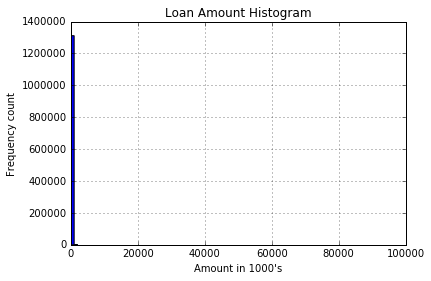

In [9]:
'''Looks like there are some outliers, We should plot a visual to gain more understanding'''
result['Loan_Amount_000'].hist(bins=100)
plt.title("Loan Amount Histogram")
plt.xlabel("Amount in 1000's")
plt.ylabel("Frequency count")

fig = plt.gcf()
plt.show()

In [10]:
'''Looks like the data is heavily skewed and by looking at the maximum loan amount being 99625, this clearly hints us that
there's been a human recording error (as all loan amounts are mentioned in the scale of 1000s)'''
sorted(result['Loan_Amount_000'].tolist(),reverse=True)[:10]

[99625, 99306, 98285, 98279, 97928, 97757, 96327, 96257, 96208, 95985]

In [11]:
'''Lets look at the applicant income rates for all the absurd loan amount values'''
result[['Applicant_Income_000','Loan_Amount_000']][result['Loan_Amount_000'].isin(sorted(result['Loan_Amount_000'].tolist(),reverse=True)[:10])]

,Applicant_Income_000,Loan_Amount_000
557875,32,98279
1030811,32,96208
1320882,32,97928
1320885,32,97757
1320906,32,96257
1320941,31,95985
1320978,33,99625
1321003,33,99306
1321069,32,96327
1321073,32,98285


## General Findings:

https://www.fhfa.gov/DataTools/Downloads/Pages/Conforming-Loan-Limits.aspx

https://www.fanniemae.com/singlefamily/loan-limits

From the above two links I got an overall idea about the maximum home loan amount that can possibly be borrowed from a bank and by looking at our above data, it clearly doesn't make sense with regards to the applicants income and their requested loan amount. Hence we need to clean these type of human made errors (standardize our dataset) before proceeding further. 

We will use 1800 as our cutoff threshold value (assuming from the above two links) as 1.8 million could be the maximum limit for home loans.

In [12]:
'''Lets normalize our dataset and then look at our new descriptive stats'''
result.loc[result['Loan_Amount_000'] > 1800,'Loan_Amount_000'] = (result['Loan_Amount_000']/1000).apply(np.floor)
result['Loan_Amount_000'].describe()

count    1.321158e+06
mean     2.676178e+02
std      1.690317e+02
min      1.000000e+00
25%      1.530000e+02
50%      2.340000e+02
75%      3.470000e+02
max      1.800000e+03
Name: Loan_Amount_000, dtype: float64

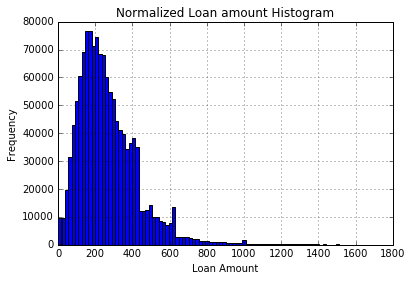

In [13]:
'''Lets plot the loan amount data after normalization'''
result['Loan_Amount_000'].hist(bins=100)
plt.title("Normalized Loan amount Histogram")
plt.xlabel("Loan Amount")
plt.ylabel("Frequency")

fig = plt.gcf()
plt.show()

The above plot looks more cleaner and looks right skewed but that's totally fine as its evident that only a few rich parties would request/apply for loan amounts beyond a million dollar. We have now standardized our data. 

In [14]:
'''Just to verify that our assumption proves to be right and to make sure if there is any applicant who's income 
is considerably low (we will use 500k as the cuttoff applicant income limit for loans above 1 million) while 
his loan application is above a million dollar'''

result[['Applicant_Income_000','Loan_Amount_000']][(result['Loan_Amount_000'] > 1000) & (result['Loan_Amount_000'] <= 1800) 
                                                   & (result['Applicant_Income_000'] < 500)][:10]

,Applicant_Income_000,Loan_Amount_000


In [15]:
result[['Applicant_Income_000','Loan_Amount_000']][(result['Loan_Amount_000'] > 1000) & (result['Loan_Amount_000'] <= 1800) 
                                                   & (result['Applicant_Income_000'] > 500)][:10]

,Applicant_Income_000,Loan_Amount_000
691,0425,1210.0
1723,0482,1204.0
2011,0665,1200.0
2442,0485,1195.0
3980,1382,1182.0
3995,0381,1172.0
3998,0669,1300.0
4619,0325,1080.0
5509,NA,1300.0
11763,2000,1674.0


In [16]:
'''Check for null values in the Respondent name column'''
result.Respondent_Name_TS.isnull().sum()

0

In [17]:
'''Get a hint about the MVP respondents based on total loan applications'''
rr = result[['Respondent_Name_TS', 'Loan_Amount_000']].groupby('Respondent_Name_TS').agg(['count'])
rr_plot = rr['Loan_Amount_000']['count'].copy()
rr_plot.sort(ascending=False)
print "Top 10 respondents by count of loan applications over the 3 year period"
print rr_plot[:10]

Top 10 respondents by count of loan applications over the 3 year period
Respondent_Name_TS
WELLS FARGO BANK, NA           137060
QUICKEN LOANS                   66561
BANK OF AMERICA, N.A.           48506
BRANCH BANKING AND TRUST CO     47543
SUNTRUST MORTGAGE, INC          46798
JPMORGAN CHASE BANK, NA         44010
NFCU                            33971
GEORGE MASON MORTGAGE LLC       29021
PNC BANK N.A.                   26117
CITIBANK, N.A.                  23885
Name: count, dtype: int64


C:\Users\praveenb\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


## Wells Fargo Bank and Quicken Loans seem to lead the line with regards to total loan applications received for the three year period.

In [18]:
'''Display the respondent names recorded in various years and see if they all stay the same'''
inst_data[['Respondent_ID','Agency_Code','Respondent_Name_TS','As_of_Year']].sort_values(by=['Agency_Code','Respondent_ID','Respondent_Name_TS','As_of_Year']).head()

,Respondent_ID,Agency_Code,Respondent_Name_TS,As_of_Year
14592,0000000046,1,FIRST NATIONAL BANK OF MCCONNE,2014
0,0000000047,1,FIRST FINANCIAL BANK NA,2012
7401,0000000047,1,FIRST FINANCIAL BANK NA,2013
14593,0000000047,1,FIRST FINANCIAL BANK NA,2014
1,0000000056,1,"FIRST FINANCIAL BANK, N.A.",2012


From the above table we can notice that the respondent names tend to get updated and are not constant throughout the years. We can probably create a utility search function that provides end users an idea of whether the respondent name that they are about to enter is already present. This may help in preventing the creation of duplicative records. 

In [19]:
'''Simplistic search respondents tool to avoid duplicate entries from being created'''
'''Inputs: year,agency_code, respondent name
    Outputs: A list of suggestions that already exist in the dataset for that specific year and agency code'''
def check_respondents(inst_df,year,agency_code,respondent_name):
    ins_data_subset = inst_df[(inst_df['As_of_Year'] == year) & (inst_df['Agency_Code'] == agency_code)]
    resp_id_list = ins_data_subset[['Respondent_ID','Respondent_Name_TS']]
    d = resp_id_list.to_dict(orient='records')
    unique_resp_names = {}
    for i in d:
        if i['Respondent_ID'] not in unique_resp_names:
            unique_resp_names[i['Respondent_ID']] = i['Respondent_Name_TS']

    search = {}
    length = len(re.sub(' +',' ',respondent_name.lower()).split())
    if length > 1:
        for k,v in unique_resp_names.iteritems():
            grams = [v.split()[g:g+length] for g in xrange(len(v.translate(None,string.punctuation).lower().split())-length+1)]
            Join = [' '.join(i).lower() for i in grams]
            if respondent_name.lower() in Join:
                search[k] = v

    if len(search) != 0:
        print "Looks like we already have a few matches!! You can decide from the list below. \n"
        print "Respondent_ID:   Respondent_Name_TS"
        for k,v in search.iteritems():
            print k+"   :   "+v
            
    return

'''Enter search string ,year and agency_code'''
check_respondents(inst_data,2012,1,'first financial bank na')  

Looks like we already have a few matches!! You can decide from the list below. 

Respondent_ID:   Respondent_Name_TS
0000000047   :   FIRST FINANCIAL BANK NA


In [20]:
'''Similar function to quickly check if the respondent Id exists in that specific year and within that agency code'''
def check_respondent_ID(inst_data,year,agency_code,resp_id):
    ins_data_subset = inst_data[(inst_data['As_of_Year'] == year) & (inst_data['Agency_Code'] == agency_code)]
    resp_id_list = ins_data_subset['Respondent_ID']
    c = [d for d in resp_id]
    if len(c) < 10:
        new_id = resp_id.zfill(10)
        if new_id in resp_id_list.tolist():
            print ins_data_subset[['Respondent_ID','Respondent_Name_TS']][inst_data['Respondent_ID'] == new_id]
        else:
            print "No record found."
    else:
        if resp_id in resp_id_list.tolist():
            print ins_data_subset[['Respondent_ID','Respondent_Name_TS']][inst_data['Respondent_ID'] == resp_id]
        else:
            print "No record found."
    return
    
'''Enter three module parameters'''    
check_respondent_ID(inst_data,2012,1,'56')

  Respondent_ID          Respondent_Name_TS
1    0000000056  FIRST FINANCIAL BANK, N.A.


C:\Users\praveenb\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


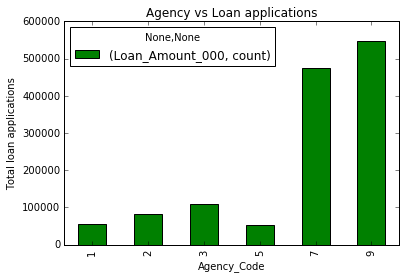

In [21]:
'''Plot to see which agency has the most loan applications'''
agencywize_grouped = result[['Agency_Code', 'Loan_Amount_000']].groupby('Agency_Code').agg(['count'])
agencywize_grouped.plot(kind='bar',color='green')
plt.title("Agency vs Loan applications")
plt.ylabel("Total loan applications")

Agencies 7 and 9 seem to have more popular and well established respondent's who indeed get the most number of loan applicants for all three years combined

In [22]:
'''Another column which might be useful in our analysis is the Applicant_Income_000 - as hinted previously, this column
helped us in our data normalization of loan_amounts'''
result.Applicant_Income_000.describe()

count     1321158
unique       2316
top          NA  
freq       117853
Name: Applicant_Income_000, dtype: object

In [23]:
'''The stats clearly indicates that the datatype of this column is a string object - we need to convert that first'''
'''Check if the column has any NA values'''
result.Applicant_Income_000.str.contains('NA').any()

True

In [24]:
'''Lets replace all NA values with actual NaN values and its always a best practice to check for white spaces before we start
our data cleaning process'''
result.Applicant_Income_000 = result.Applicant_Income_000.str.strip()
result.Applicant_Income_000.replace('NA',np.nan,inplace=True)
print result.Applicant_Income_000.isnull().sum()

117853


In [25]:
'''The amount of Null values in this column is quite understandable as not all of us would agree to disclose our income 
related information. We will ignore these null values as it is and convert other values to numeric.'''
result.Applicant_Income_000 = pd.to_numeric(result.Applicant_Income_000, errors='coerce')
result.Applicant_Income_000.dtype


dtype('float64')

In [26]:
#Just checking
result[:5]

,Agency_Code,Applicant_Income_000,As_of_Year,Census_Tract_Number,County_Code,FFIEC_Median_Family_Income,Loan_Amount_000,MSA_MD,Number_of_Owner_Occupied_Units,Respondent_ID,...,Agency_Code_Description,Lien_Status_Description,Loan_Type_Description,State,County_Name,Conforming_Limit_000,Conventional_Status,Conforming_Status,Conventional_Conforming_Flag,Respondent_Name_TS
0,3,84.0,2012,0207.00,079,00054900,94.0,16620,00001545,0000000384,...,FDIC,First Lien,Conventional,WV,PUTNAM,417.0,Conventional,Conforming,Y,THE OHIO VALLEY BANK COMPANY
1,3,84.0,2012,9556.00,043,00054900,133.0,16620,00001548,0000000384,...,FDIC,First Lien,Conventional,WV,LINCOLN,417.0,Conventional,Conforming,Y,THE OHIO VALLEY BANK COMPANY
2,3,53.0,2012,9556.00,043,00054900,70.0,16620,00001548,0000000384,...,FDIC,First Lien,Conventional,WV,LINCOLN,417.0,Conventional,Conforming,Y,THE OHIO VALLEY BANK COMPANY
3,3,85.0,2012,0206.01,079,00054900,102.0,16620,00001935,0000000384,...,FDIC,First Lien,Conventional,WV,PUTNAM,417.0,Conventional,Conforming,Y,THE OHIO VALLEY BANK COMPANY
4,3,38.0,2012,0107.01,039,00054900,112.0,16620,00001492,0000000384,...,FDIC,First Lien,Conventional,WV,KANAWHA,417.0,Conventional,Conforming,Y,THE OHIO VALLEY BANK COMPANY


In [27]:
'''Check if the applicant income column has standardized values'''
result.Applicant_Income_000.describe()

C:\Users\praveenb\Anaconda2\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


count    1.203305e+06
mean     1.180193e+02
std      1.226957e+02
min      0.000000e+00
25%               NaN
50%               NaN
75%               NaN
max      9.999000e+03
Name: Applicant_Income_000, dtype: float64

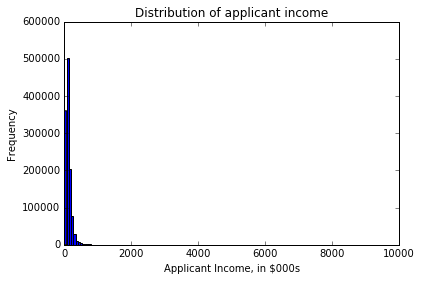

In [28]:
result['Applicant_Income_000'].plot(kind='hist',bins=150,title='Distribution of applicant income')
plt.xlabel('Applicant Income, in $000s')
plt.show()

# Part - 3

## Data visualization

Hypothesis: I propose that Change Financial should enter the home loans market in atleast 2 out of 5 states. 

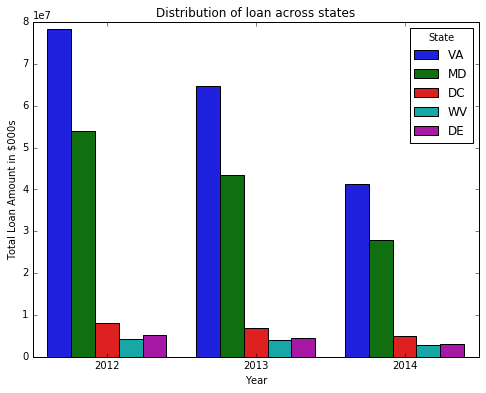

In [29]:
'''Lets start with an overview of how the states are performing with regards to total loan amount spent in the 
        last three years'''
df_ld = result[['Loan_Purpose_Description', 'Loan_Amount_000', 'As_of_Year']]
df_co = result[['Conforming_Status', 'Loan_Amount_000', 'As_of_Year']]
df_lt = result[['Loan_Type_Description', 'Loan_Amount_000', 'As_of_Year']]
la_year = result.groupby(by=['As_of_Year','State'])['Loan_Amount_000'].sum()
df_la_year = pd.DataFrame(data=la_year,index=None)
df_la_year.reset_index(inplace=True)

# plot
sns.mpl.rc("figure", figsize=(8,6))
fig = sns.barplot(x='As_of_Year',y='Loan_Amount_000',data=df_la_year,
                  hue='State', hue_order=['VA','MD','DC','WV','DE'])
fig.set_title('Distribution of loan across states')
fig.set_xlabel('Year')
fig.set_ylabel('Total Loan Amount in $000s')
fig.grid(b='off')


Looks like virginia and maryland are the two dominant states in the past three years when it comes to total loan amount sanctioned to applicants. But, we can also see that there's been a decline in the trend as years progressed. We may need to dive deeper to analyze and retrieve more insights.

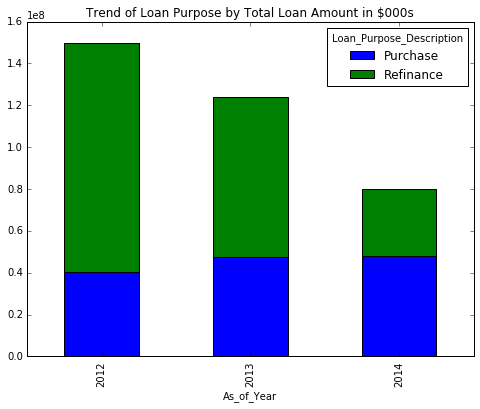

In [30]:
Loan_Purpose_amount = result.groupby(by=['As_of_Year','Loan_Purpose_Description'])['Loan_Amount_000'].sum()
Loan_Purpose_amount.unstack().plot(kind='bar',stacked=True,
                                 figsize=(8,6),
                                 title='Trend of Loan Purpose by Total Loan Amount in $000s',
                                 subplots=False)

Now, out of the two types of loan's being sanctioned. Refinance loan purpose has received more number of applications in the past when compared to the Purchase loan purpose option. But again, there's been a slight decline in the overall loan amount (refinance) spent by respondents as it looks like there could be a significant drop in the demand for refinance by looking at the years 2012 and 2014. On the contrary we can notice that the Purchase purpose loan has been gaining interest amongst customers off late.

In the below bar chart we can compare the count of different loan application purposes across states. 

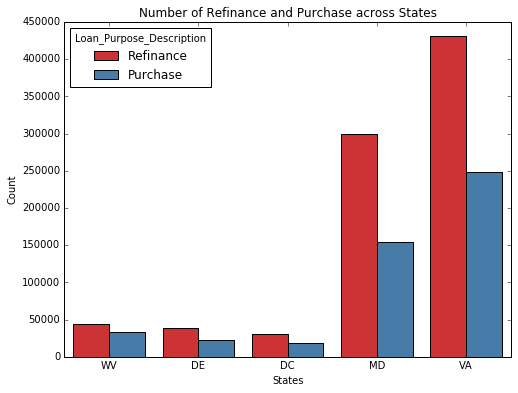

In [31]:
plt.figure(figsize=(8,6))
sns.countplot(x ='State', data = result, hue = 'Loan_Purpose_Description', palette = 'Set1')
plt.ylabel('Count')
plt.xlabel('States')
plt.title('Number of Refinance and Purchase across States')

The above graph hints us that Refinance purpose loans have been dominant across all states and specifically in Maryland and Virginia. Next we should try and look at the trend in Refinance loans and see if it has been positive over the years or not so that we could eventually arrive at a decision to suggest "Change Financial" about its next move.  

                           count    2012    2013    2014
Loan_Purpose_Description                                
Purchase                  147364  147364  166066  164698
Refinance                 410524  410524  306891  125615


C:\Users\praveenb\Anaconda2\lib\site-packages\pandas\tools\plotting.py:968: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


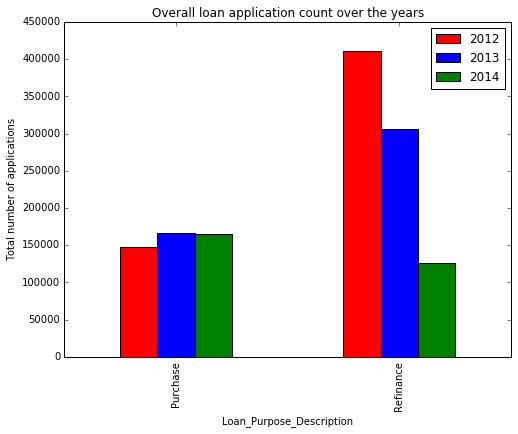

In [32]:
df_ld_grouping = df_ld[df_ld.As_of_Year == 2012].groupby('Loan_Purpose_Description').Loan_Purpose_Description.agg(['count'])
for year in [2012, 2013, 2014]:
    df_ld_grouping[year] = df_ld[df_ld.As_of_Year == year].groupby('Loan_Purpose_Description').Loan_Purpose_Description.agg(['count'])
print df_ld_grouping
df_ld_grouping.drop(df_ld_grouping.columns[[0]], axis=1).plot(kind='bar',colors = 'rbg')
plt.ylabel("Total number of applications")
plt.title("Overall loan application count over the years")

The above stat table clearly says a lot about the drop in refinance sector of loan applications. There's been a massive 69% percent drop in the incoming applications which is definitely not a good sign. As we do not have enough data to unravel the reason behind this negative trend we cannot get into a conclusion on why this has happened over the years. 

Before we drill into specific states and learn more about the nature of refinance and purchase loans in each state let's create a bar plot that gives us information on whether most of these Purchase/Refinance loans fall under the 'Conforming' limit or not.

                    count    2012    2013    2014
Conforming_Status                                
Conforming         535354  535354  451156  272041
Jumbo               22534   22534   21801   18272


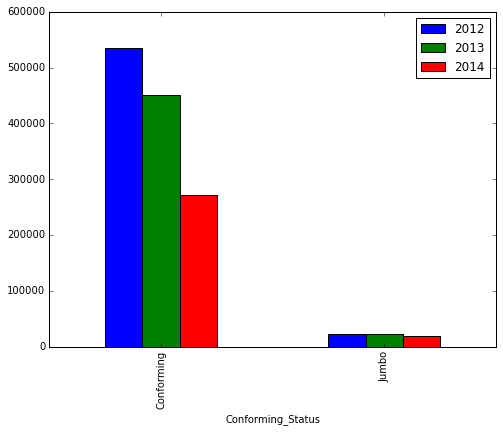

In [33]:
df_co_grouping = df_co[df_co.As_of_Year == 2012].groupby('Conforming_Status').Conforming_Status.agg(['count'])
for year in [2012, 2013, 2014]:
    df_co_grouping[year] = df_co[df_co.As_of_Year == year].groupby('Conforming_Status').Conforming_Status.agg(['count'])
print df_co_grouping
df_co_grouping.drop(df_co_grouping.columns[[0]], axis=1).plot(kind='bar')

Well, most of the loans fall under the conforming limit which is good. 

                        count    2012    2013    2014
Loan_Type_Description                                
Conventional           397874  397874  339092  192204
FHA insured             80228   80228   65364   42133
FSA/RHS guaranteed       7521    7521    8767    8375
VA guaranteed           72265   72265   59734   47601


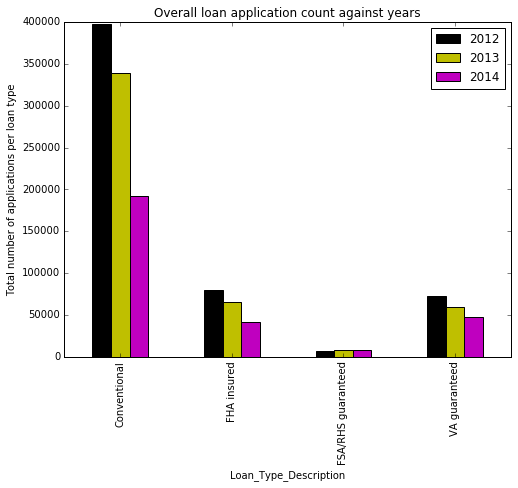

In [34]:
df_lt_grouping = df_lt[df_lt.As_of_Year == 2012].groupby('Loan_Type_Description').Loan_Type_Description.agg(['count'])
for year in [2012, 2013, 2014]:
    df_lt_grouping[year] = df_lt[df_lt.As_of_Year == year].groupby('Loan_Type_Description').Loan_Type_Description.agg(['count'])
df_lt_grouping.drop(df_lt_grouping.columns[[0]], axis=1).plot(kind='bar',colors = 'kymc')
print df_lt_grouping
plt.ylabel("Total number of applications per loan type")
plt.title("Overall loan application count against years")

Here we can again notice that the majority of loan applications received belong to the conventional type which is a safe bet. Also, another important point to be noted is the decrease in loan applications over the years irrespective of their type. This again hints us that market is unstable and it would be risky to invest if such trends continue to pregress in a similar direction. 

Next up, we need to know the average loan amount across all states to decide on probable state where Change Financial could start their venture. 

(-1.108123991043692,
 1.016424487557797,
 -1.0193915961087125,
 1.0133254077002869)

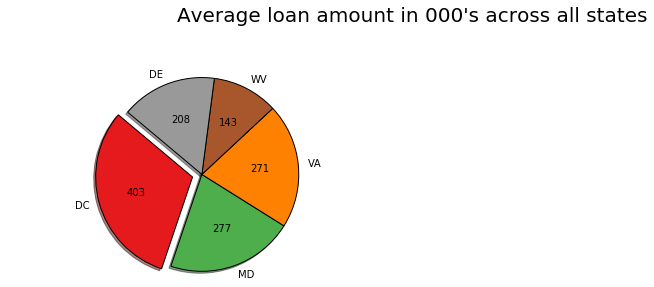

In [35]:
'''Generate a single pie char that displays average loan amount across all states'''
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v:d}'.format(v=val)
    return my_autopct

plt.figure(figsize=(15,12))
plt.suptitle("Average loan amount in 000's across all states",fontsize=20)
plt.subplot(321)
x = ['DC','MD','VA','WV','DE']
y = [ result['Loan_Amount_000'][result['State'] == i].mean() for i in ['DC','MD','VA','WV','DE']]
cs=cm.Set1(np.arange(5)/4.)
explode = (0.1, 0, 0, 0, 0)
plt.pie(y, labels=x, explode=explode,colors=cs,autopct=make_autopct(y),
         shadow=True, startangle=140)
plt.axis('equal')

(-1.1066637811092548,
 1.008834660938533,
 -1.0226902039125541,
 1.0120718742569428)

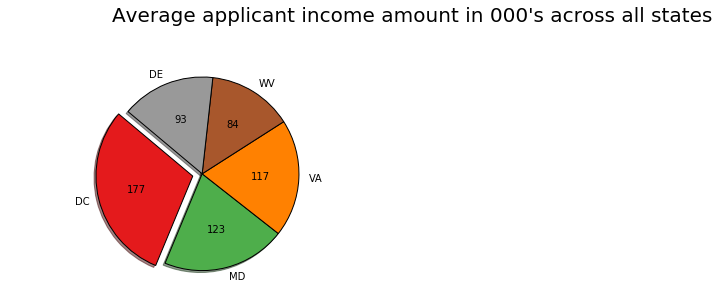

In [36]:
plt.figure(figsize=(15,12))
plt.suptitle("Average applicant income amount in 000's across all states",fontsize=20)
plt.subplot(321)
x = ['DC','MD','VA','WV','DE']
y = [ result['Applicant_Income_000'][result['State'] == i].mean() for i in ['DC','MD','VA','WV','DE']]
cs=cm.Set1(np.arange(5)/4.)
explode = (0.1, 0, 0, 0, 0)
plt.pie(y, labels=x, explode=explode,colors=cs,autopct=make_autopct(y),
         shadow=True, startangle=140)
plt.axis('equal')

The average loan amount in DC is very high. But this may be a false alarm as the total number of applications from DC is quite less when compared to VA and MD. There might have also been an outlier applicant who would have loaned a huge sum which would have obviously increased mean value. We need more data to justify if this is a real case to consider. 

Deeper analysis also is required with regards to the DC state applications. Now that we've witnessed the average income at DC is above both MD and VA we may want to expand our research specifically to DC to try and understand the reason behind less number of total loan applications received throughout the years. 

Finally, Lets also look at some of the established leaders in the current market across all states. 

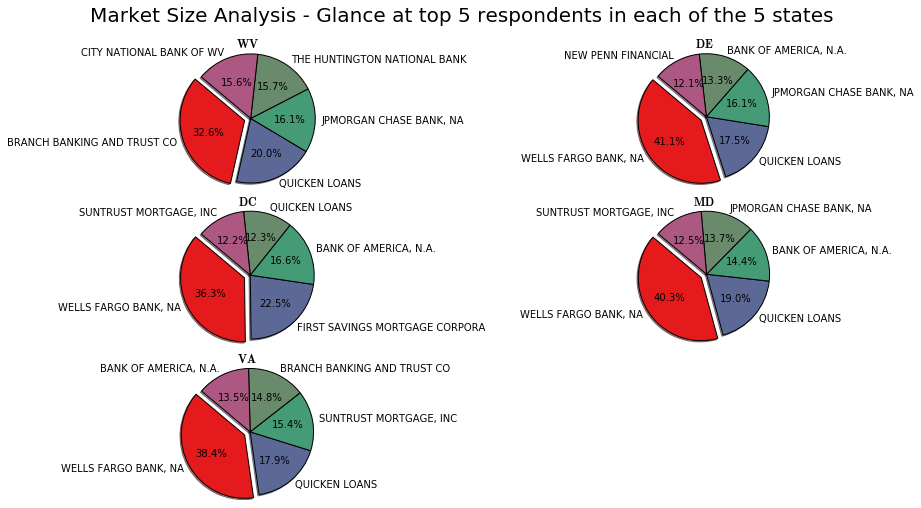

In [40]:
'''Plot a pie chart that gives percentage details of top 5 respondents estimated by total loan applications '''
def plot_market_share(df):
    
    plt.figure(figsize=(15,8))
    pos = 321
    plt.suptitle('Market Size Analysis - Glance at top 5 respondents in each of the 5 states', fontsize=20)
    for state in list(df['State'].unique()):
        plt.subplot(pos)
        pos+=1
        sub_df = df.groupby(['State','Respondent_ID']).size()
        get_resp_index = list(np.argsort(sub_df[state]) [::-1] [:5])   
        resp_name = []
        resp_count = []
        for i in range(0,5):
            tmp = sub_df[state].index.get_level_values(0)[get_resp_index[i]]
            resp_name.append(list(df[df['Respondent_ID']==tmp]['Respondent_Name_TS'][:1])[0])
            resp_count.append(sub_df[state][get_resp_index[i]])
            
        labels = pd.DataFrame({'Respondent_Name': resp_name, 'Frequency': resp_count})
        
        x = labels['Respondent_Name']
        y = labels['Frequency']
        cs=cm.Set1(np.arange(10)/10.)
        explode = (0.1, 0, 0, 0, 0)
        plt.pie(y, labels=x, explode=explode,colors=cs,
                autopct='%1.1f%%', shadow=True, startangle=140)
        plt.title(r"$\bf{" + state + "}$")
        plt.axis('equal')

    return

plot_market_share(result)


Wells Fargo and Quicken loans share the major piece of the pie in almost all states closely followed by Bank of America, SunTrust and the JPMorgan Chase group. 

# Final Thoughts:

In accordance to our proposal in the beginning of the data visualization section, There are few findings which I would like to list down,
    1. After a few initial visualization, we can say that Maryland and Virginia are the front liners with regards to the Home Loans market. 
    2. Due to large number of loan applications and relatively high applicant income - its ideal for Change Financial to consider both Maryland or Virginia states. 
    3. It is recommended that Change Financial should focus on providing "Purchase" type of home loans while working to enter either Maryland or Virginia where the Purchase trend is stable and they should prefer to go with "Refinance" if they decide to approach the states that have recorded less activity ('WV','DC','DE') in the past but have always had greater number of applications when compared to "Purchase" type loans. 
    4. More research work has to be done with regards to external factors that could have had an impact in the decline of applications to understand if the trend is as a result of a cause and effect scenario.
    5. In general, the rate at which a company grows depends a lot on its brand impression among general public people who would get influenced by the actual business product that the company offers and the rates at which they are offered. So, If Change Financial can come up with eye catch and at the same time competetive offers then they should eventually get customers in no time. 
    